In [14]:
import os
import sys
cwd = os.getcwd()
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, os.path.join(cwd, "../"))

import pickle
import torch
import importlib
import numpy as np
import pandas as pd
import copy

import src.bin.tensorify as tensorify
import src.utils.data_conversion_utils as conversion_utils
import src.data_manager.student_life_var_binned_data_manager as data_manager
import src.bin.trainer as trainer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn import metrics

from torch import nn
from src import definitions
from src.bin import validations
from src.bin import statistics
from src.bin import plotting
from src.utils.read_utils import read_pickle
from src.utils import student_utils
from src.data_manager import sub_sampler
from src.data_manager import cross_val
from src.data_manager import helper as data_manager_helper

from tabulate import tabulate 
import src.models.simple as simple_models
import src.models.gatis_mp as models

pd.set_option('max_rows', 10000)

%load_ext autoreload
%autoreload 2
feature_list = data_manager.FEATURE_LIST

##### Pickle ######
# data = read_pickle('../data/training_data/most_representative_6_hr_b_imputed_normalized_prev_stress_data.pkl')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import torch.utils.data as torch_utils
from torch.utils.data import DataLoader
from tqdm import tqdm
conversion_utils.normalize

<function src.utils.data_conversion_utils.normalize(data_frame: pandas.core.frame.DataFrame, norm_type='mean', df_mean: pandas.core.series.Series = None, df_std: pandas.core.series.Series = None, df_min: pandas.core.series.Series = None, df_max: pandas.core.series.Series = None) -> pandas.core.frame.DataFrame>

In [16]:
data_path = module_path + "/data"
gfp = lambda x: data_path + x
# 1,3,5,9,13, 49
# file_path = gfp('/gatis-new-23.pkl')
# file_path = gfp('/gatis-old-23.pkl')
file_path = gfp('/gatis-new-49.pkl')
# file_path = gfp('/gatis-old-49.pkl')
# file_path = data_path + "/gatis_all.pkl"
# file_path = data_path + "/gatis-old-all.pkl"
data = pd.read_pickle(file_path)
display(data[:3])

,time,distance,displacement,distance_std,unique_tile_count,convex_hull_area,tile_change,cluster,entropy,start_term,end_term,mid_term,weekends,stress,student_id
73,2013-04-20 05:14:22,4.809793,0.593052,0.148694,1.0,919.462248,0.0,6.0,2.829342,0.0,0.0,1.0,1.0,1.0,10
24,2013-04-21 17:20:08,0.775786,0.456714,0.053514,1.0,25.719984,0.0,2.0,2.257372,0.0,0.0,1.0,1.0,2.0,3
7,2013-04-03 08:22:11,44.803196,7.988767,1.985968,1.0,144195.933899,31.0,6.0,2.337196,1.0,0.0,0.0,0.0,0.0,45


In [17]:
learning_rate = 0.001
momentum = 0.98
n_epochs = 300
batch_size=32
np.set_printoptions(precision=3)

In [18]:
# train_loader = DataLoader([X_train.values, y_train.values] ,batch_size=32, shuffle=True)
# print(train_loader)
def pd_to_loader(X, Y, batch_size=32, shuffle=False):
    xt_train,yt_train = torch.Tensor(X), torch.LongTensor(Y)
    yt_train = yt_train.view(-1, )
    tensor_dataset_train = torch_utils.TensorDataset(xt_train, yt_train)
    loader = DataLoader(tensor_dataset_train, batch_size=batch_size, shuffle=shuffle)
    return loader
    

features_cols = ['distance', 'displacement', 'distance_std', 'unique_tile_count', 'convex_hull_area', 'tile_change', 
                 'cluster', 'entropy', 'start_term', 'end_term', 'mid_term', 'weekends']
STUDENTS_LIST = set([1, 2,4, 7,10, 22, 24, 33, 42, 46, 49, 53, 57])

all_cols = list(data)
all_cols.remove('stress')
all_cols.remove('student_id')
all_cols.remove('time')
features = data[all_cols + ['student_id','stress']]
# display(features[:3])

split_X = features.values.tolist()
split_y = features['student_id'].tolist()
split_y2 = features['stress'].tolist()
split_student_labels = ['{}_{}'.format(split_y[i], int(split_y2[i])) for i in range(len(split_y))]
kfolds = StratifiedKFold(n_splits=5)
loaders = []

print(int(features.iloc[0]['student_id']) in STUDENTS_LIST)
for fold, (train_idx, test_idx) in enumerate(kfolds.split(split_X, split_student_labels)):

    train_idx = np.random.choice(train_idx, min(len(train_idx), 900), replace=False).tolist()
    test_idx  = np.random.choice(test_idx, min(len(test_idx), 250), replace=False).tolist()
    
    Xy_train = pd.DataFrame([features.iloc[i] for i in train_idx])
    Xy_test  = pd.DataFrame([features.iloc[i] for i in test_idx])

#     _test = [features.iloc[i] 
#         if (int(features.iloc[i]['student_id']) in STUDENTS_LIST) else
#              None
#              for i in test_idx]
#     Xy_test  = pd.DataFrame(list(filter(lambda x: x is not None, _test)))
#     print(set(Xy_test['student_id'].values))

    X_train, y_train = Xy_train[features_cols], Xy_train['stress']
    X_test, y_test   = Xy_test[features_cols], Xy_test['stress']
    X_train, y_train = conversion_utils.normalize(X_train), pd.DataFrame(y_train).values
    X_test, y_test = conversion_utils.normalize(X_test), pd.DataFrame(y_test).values
    
    X_train = X_train.values
    X_test  = X_test.values
    print("Fold: {} train: {} test: {}".format(fold, len(Xy_train), len(Xy_test)))
    train_loader = pd_to_loader(X_train, y_train,batch_size=batch_size, shuffle=True)
    test_loader = pd_to_loader(X_test, y_test, batch_size=batch_size)
    loaders.append((train_loader, test_loader))
    

True


/Users/nsimsiri/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Fold: 0 train: 900 test: 250
Fold: 1 train: 900 test: 250
Fold: 2 train: 900 test: 250
Fold: 3 train: 900 test: 250
Fold: 4 train: 900 test: 250


In [19]:
def eval_network(loader, net, criterion, optimizer, training=False):
    running_loss = 0.0
    final_preds, final_labels = [], []
    if training:
        net.train()
    else:
        net.eval()
    for i, minibatch in enumerate(loader, 0):
        batch, labels = minibatch
        optimizer.zero_grad()
        logits = net(batch)
        preds = torch.argmax(logits, dim=1)
        final_preds += preds.numpy().tolist()
        final_labels += labels.numpy().tolist()
        loss = criterion(logits, labels)
        if training:
            loss.backward()
            optimizer.step()
        running_loss += loss.item()
    return running_loss, final_labels, final_preds

In [20]:
net = models.GatisNet()
print(net)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

GatisNet(
  (dense): Sequential(
    (0): Linear(in_features=12, out_features=57, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.35)
    (3): Linear(in_features=57, out_features=35, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25)
    (6): Linear(in_features=35, out_features=35, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.15)
    (9): Linear(in_features=35, out_features=3, bias=True)
    (10): Softmax()
  )
)


In [21]:
running_loss = 0.0
best_test_f1 = 0
best_val_f1 = 0

fold_train_scores = []
fold_test_scores  = []
fold_train_loss   = []
fold_test_loss    = []

for fold, (train_loader, test_loader) in enumerate(loaders):
        net = models.GatisNet()

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
        
        loss_over_epochs, scores_over_epochs = plotting.get_empty_stat_over_n_epoch_dictionaries()
        best_split_score = [0.0,0.0,0.0]
        
        for epoch in range(n_epochs):
            
            train_loss, train_labels, train_preds = eval_network(train_loader, net, criterion, optimizer, training=True)
            test_loss, test_labels, test_preds = eval_network(test_loader, net, criterion, optimizer)
            
            train_scores = metrics.precision_recall_fscore_support(train_labels, train_preds, average='weighted')
            test_scores = metrics.precision_recall_fscore_support(test_labels, test_preds, average='weighted')

            scores_over_epochs['train_scores'].append(train_scores)
            scores_over_epochs['val_scores'].append(test_scores)
            scores_over_epochs['test_scores'].append(test_scores)

            loss_over_epochs['train_loss'].append(train_loss)
            loss_over_epochs['val_loss'].append(test_loss)
            loss_over_epochs['test_loss'].append(test_loss)
            if (best_split_score[2] < test_scores[2]):
                best_split_score = test_scores[:-1]

#             if epoch%5 == 0:
#                 print("xxxxxxxxxxxxxx epoch: {} xxxxxxxxxxxxxx".format(epoch))
#                 plotting.plot_score_over_n_epochs(scores_over_epochs, score_type='f1', fig_size=(8,5))
#                 plotting.plot_loss_over_n_epochs(loss_over_epochs, fig_size=(8, 5))
#                 print("Cofusion Matrix For Test Set: ")
#                 print(tabulate( metrics.confusion_matrix(test_labels, test_preds)))
        #         print("Predicted Label Distribution:")
        #         print(statistics.get_train_test_val_label_counts_from_predictions(train_preds, val_preds, test_preds))
        fold_test_scores.append(best_split_score)
        print("SPLIT---")
        print(best_split_score,)

avg_test_scores  = np.mean(np.array(fold_test_scores), axis=0)
print("\n")
print("X==X"*5)
for xx in fold_test_scores:
    print(xx)
print(fold_test_scores)
print("best_test_f1: {}".format(avg_test_scores))
# print("best_val_f1: {}".format(best_val_f1))
    

/Users/nsimsiri/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/Users/nsimsiri/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SPLIT---
(0.5580465293668955, 0.516, 0.4657678584128538)
SPLIT---
(0.4756688741721854, 0.456, 0.41544399460188935)
SPLIT---
(0.43862418396678376, 0.464, 0.4424439668553144)
SPLIT---
(0.4917029564242679, 0.48, 0.4287031286601763)
SPLIT---
(0.480624636531853, 0.488, 0.47830926764424864)


X==XX==XX==XX==XX==X
(0.5580465293668955, 0.516, 0.4657678584128538)
(0.4756688741721854, 0.456, 0.41544399460188935)
(0.43862418396678376, 0.464, 0.4424439668553144)
(0.4917029564242679, 0.48, 0.4287031286601763)
(0.480624636531853, 0.488, 0.47830926764424864)
[(0.5580465293668955, 0.516, 0.4657678584128538), (0.4756688741721854, 0.456, 0.41544399460188935), (0.43862418396678376, 0.464, 0.4424439668553144), (0.4917029564242679, 0.48, 0.4287031286601763), (0.480624636531853, 0.488, 0.47830926764424864)]
best_test_f1: [0.489 0.481 0.446]


In [22]:
print("best_test_f1: {}".format(avg_test_scores[2]))


best_test_f1: 0.44613364323489646


In [23]:
torch.Tensor([2222,1]).max()

tensor(2222.)

In [24]:
def get_k_fod_cross_val_splits_stratified_by_students(data: dict, n_splits=5, stratification_type="student_label"):

    splits = []

    data_keys = data['data'].keys()
    keys, labels = conversions.extract_keys_and_labels_from_dict(data)
    student_ids = conversions.extract_student_ids_from_keys(keys)
    student_ids_label = []

    for i in range(len(student_ids)):
        student_ids_label.append(str(student_ids[i]) + "_" + str(labels[i]))

    student_ids_label = np.array(student_ids_label)
    data_keys = np.array(list(data_keys))
    student_ids = conversions.convert_list_of_strings_to_list_of_ints(student_ids)

    if stratification_type == "student":
        stratification_column = student_ids
    else:
        stratification_column = student_ids_label

    print(stratification_type)

    splitter = StratifiedKFold(n_splits=n_splits, random_state=SPLITTER_RANDOM_STATE)
    for train_index, val_index in splitter.split(X=data_keys, y=stratification_column):

        splitting_dict = {}
        splitting_dict['train_ids'] = data_keys[train_index].tolist()
        splitting_dict['val_ids'] = data_keys[val_index].tolist()
        splits.append(splitting_dict)

    return splits

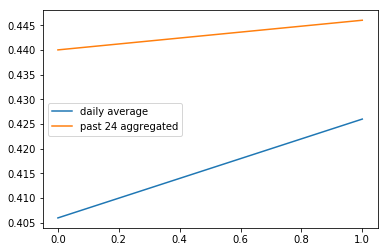

In [32]:
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

# current_data_agg = [0.582, 0.513, 0.424, 0.4003, 0.398, 0.406, 0.426]
# past_data_agg = [0.551, 0.456, 0.395, 0.392, 0.375, 0.373,  0.447, 0.402]

current_data_agg = [0.406, 0.426]
past_data_agg = [0.440, 0.446]


plt.title()
plt.plot(current_data_agg, label='daily average')
plt.plot(past_data_agg, label='past 24 aggregated')
plt.legend(loc='center left')
plt.show()

In [26]:
a = np.array([0.657, 0.61 , 0.471, 0.446, 0.436])
b = np.array([0.657, 0.634, 0.585, 0.60 , 0.583])
print(np.abs(np.array(a-b)))


[0.    0.024 0.114 0.154 0.147]
